In [1]:
# Install the necessary dependencies

import os
import sys 
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Autoencoder

## Overview

An autoencoder, also known as autoassociator or Diabolo networks, is an artificial neural network employed to recreate the given input. It takes a set of <b>unlabeled</b> inputs, encodes them and then tries to extract the most valuable information from them. They are used for feature extraction, learning generative models of data, dimensionality reduction and can be used for compression. 

Autoencoders are based on Restricted Boltzmann Machines, are employed in some of the largest deep learning applications. They are the building blocks of Deep Belief Networks (DBN).

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/VAE/mod_ID_13_final.png" width=400>

## Autoencoder Structure 

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/VAE/deep_autoencoder.png">

An autoencoder can be divided in two parts, the <b>encoder</b> and the <b>decoder</b>.

The encoder needs to compress the representation of an input. In this case we are going to reduce the dimension. The decoder works like encoder network in reverse. It works to recreate the input, as closely as possible. This plays an important role during training, because it forces the autoencoder to select the most important features in the compressed representation.

<h2>Training: Loss function</h2>

An autoencoder uses the Loss function to properly train the network. The Loss function will calculate the differences between our output and the expected results. After that, we can minimize this error with gradient descent. There are more than one type of Loss function, it depends on the type of data.The following is the formula for binary values.

$$l(f(x)) = - \sum_{k} (x_k log(\hat{x}_k) + (1 - x_k) \log (1 - \hat{x}_k) \ )$$

For binary values, we can use an equation based on the sum of Bernoulli's cross-entropy.  $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output. We use this function so that if $x_k$ equals to one, we want to push $\hat{x}_k$ as close as possible to one. The same if $x_k$ equals to zero. If the value is one, we just need to calculate the first part of the formula, that is, $- x_k log(\hat{x}_k)$. Which, turns out to just calculate $- log(\hat{x}_k)$. And if the value is zero, we need to calculate just the second part, $(1 - x_k) \log (1 - \hat{x}_k) \ )$ - which turns out to be $log (1 - \hat{x}_k) $.The following is the formula for real values.

$$l(f(x)) = - \frac{1}{2}\sum_{k} (\hat{x}_k- x_k \ )^2$$

As the above function would behave badly with inputs that are not 0 or 1, we can use the sum of squared differences for our Loss function.

As it was with the above example, $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output, and we want to make our output as similar as possible to our input.

## Code

Let's build a 2-layers auto-encoder with TensorFlow to compress images to a lower latent space and then reconstruct them. And this project will be done on MNIST dataste.

In [2]:
import tensorflow as tf
import numpy as np

MNIST Dataset parameters.

In [3]:
num_features = 784 # data features (img shape: 28*28).

Training parameters.

In [4]:
learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

Network Parameters

In [5]:
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).

Prepare MNIST data.

In [6]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

Use tf.data API to shuffle and batch data.

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

Store layers weight & bias.
A random value generator to initialize weights.

In [ ]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(random_normal([num_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(random_normal([num_features])),
}

Building the encoder.

In [9]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

Building the decoder.

In [10]:
def decoder(x):
    # Decoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

Mean square loss between original images and reconstructed ones.

In [11]:
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

Adam optimizer.

In [12]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

Optimization process. 

In [13]:
def run_optimization(x):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        reconstructed_image = decoder(encoder(x))
        loss = mean_square(reconstructed_image, x)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())
    
    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

Run training for the given number of steps.

In [14]:
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    # Run the optimization.
    loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))

step: 0, loss: 0.234978
step: 1000, loss: 0.016520
step: 2000, loss: 0.010679
step: 3000, loss: 0.008460
step: 4000, loss: 0.007236
step: 5000, loss: 0.006323
step: 6000, loss: 0.006220
step: 7000, loss: 0.005524
step: 8000, loss: 0.005355
step: 9000, loss: 0.005005
step: 10000, loss: 0.004884
step: 11000, loss: 0.004767
step: 12000, loss: 0.004663
step: 13000, loss: 0.004198
step: 14000, loss: 0.004016
step: 15000, loss: 0.003990
step: 16000, loss: 0.004066
step: 17000, loss: 0.004013
step: 18000, loss: 0.003900
step: 19000, loss: 0.003652
step: 20000, loss: 0.003604


Testing and Visualization.

In [15]:
import matplotlib.pyplot as plt

Encode and decode images from test set and visualize their reconstruction.

Original Images


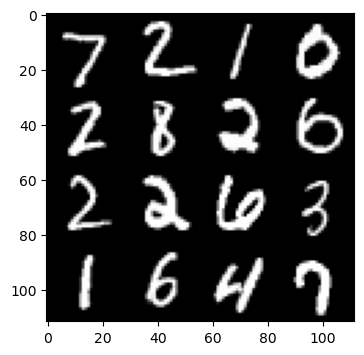

Reconstructed Images


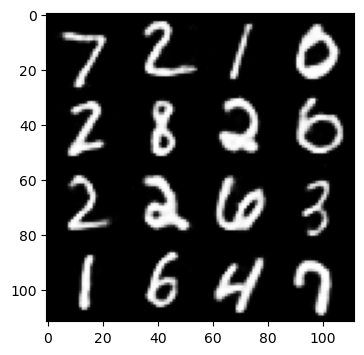

In [16]:
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

## Your turn! 🚀

Assignment - [Base denoising autoencoder dimension reduction](../assignments/base-denoising-autoencoder-dimension-reduction.ipynb)

## Self study

You can refer to this book chapter for further study:

- [deeplearningbook](https://www.deeplearningbook.org/contents/autoencoders.html)

## Acknowledgments

Thanks to [Sebastian Raschka](https://github.com/rasbt) for creating the open-source project [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20) and [Aymeric Damien](https://github.com/aymericdamien) for creating the open-source project [TensorFlow-Examples](https://github.com/aymericdamien/TensorFlow-Examples/). They inspire the majority of the content in this chapter.
